# 1. Import needed libraries

In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Preprocessing

## 2.1 Load data

In [4]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [5]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [6]:
tr_df = train_df('/kaggle/input/brain-tumor-mri-dataset/Training')

In [7]:
tr_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [8]:
ts_df = test_df('/kaggle/input/brain-tumor-mri-dataset/Testing')

In [9]:
ts_df

,Class Path,Class
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
...,...,...
1306,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1307,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1308,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1309,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma


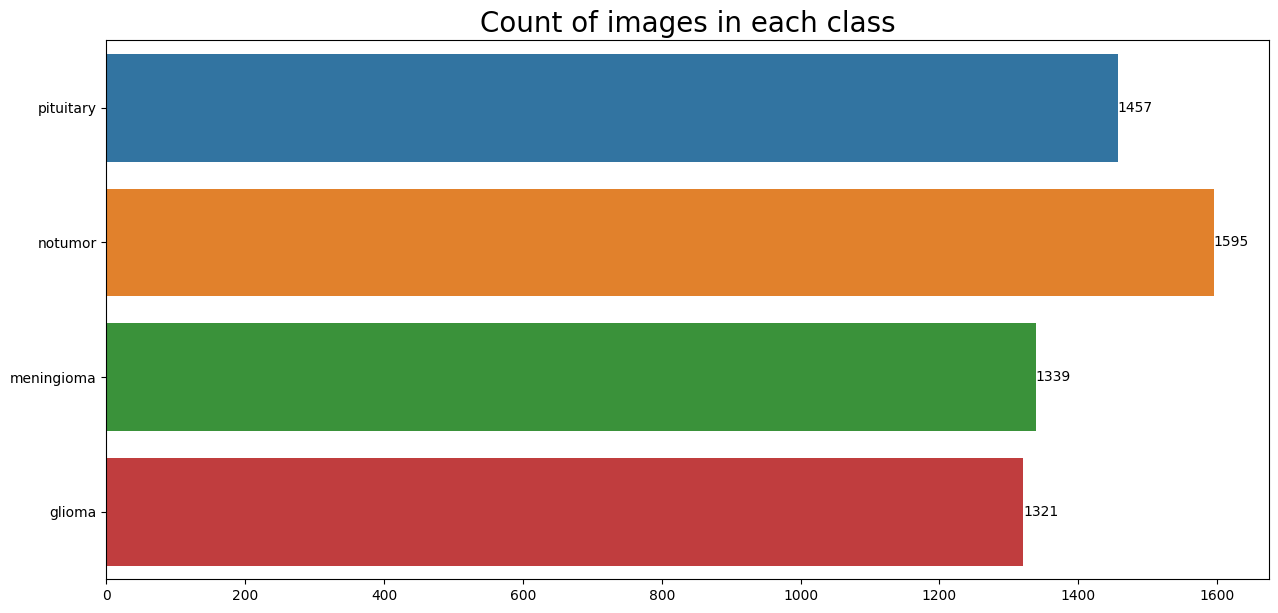

In [10]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

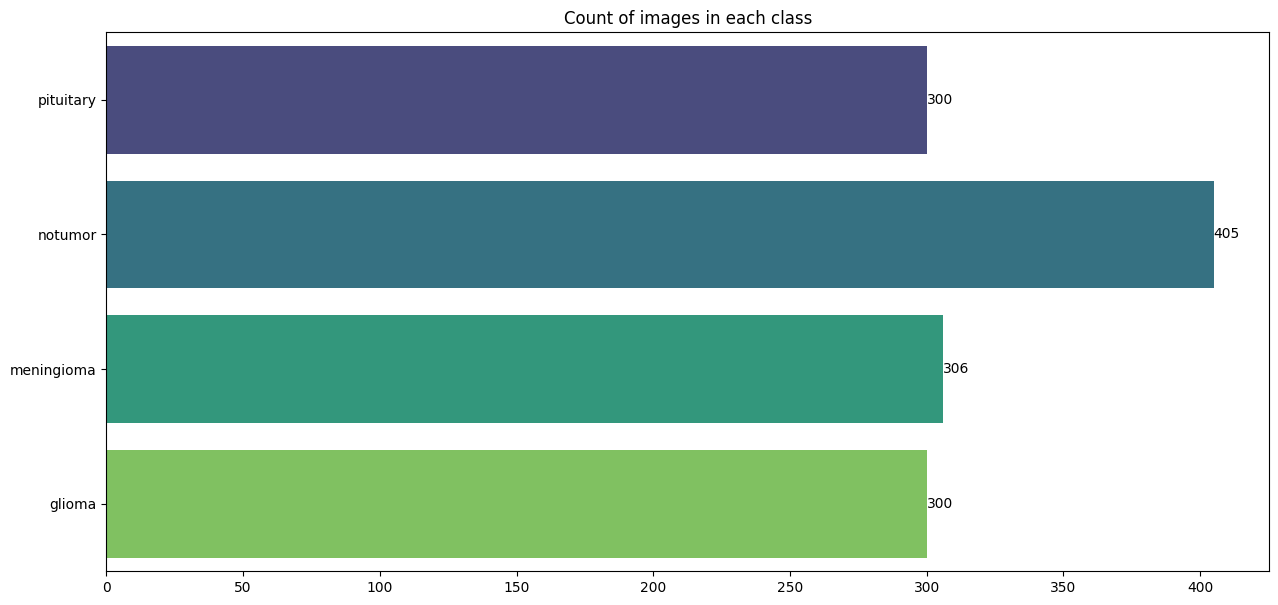

In [11]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [13]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [14]:
valid_df

,Class Path,Class
1076,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
851,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
1014,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
1138,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
940,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
...,...,...
869,/kaggle/input/brain-tumor-mri-dataset/Testing/...,meningioma
664,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor
1154,/kaggle/input/brain-tumor-mri-dataset/Testing/...,glioma
482,/kaggle/input/brain-tumor-mri-dataset/Testing/...,notumor


## 2.3 Data preprocessing

In [15]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

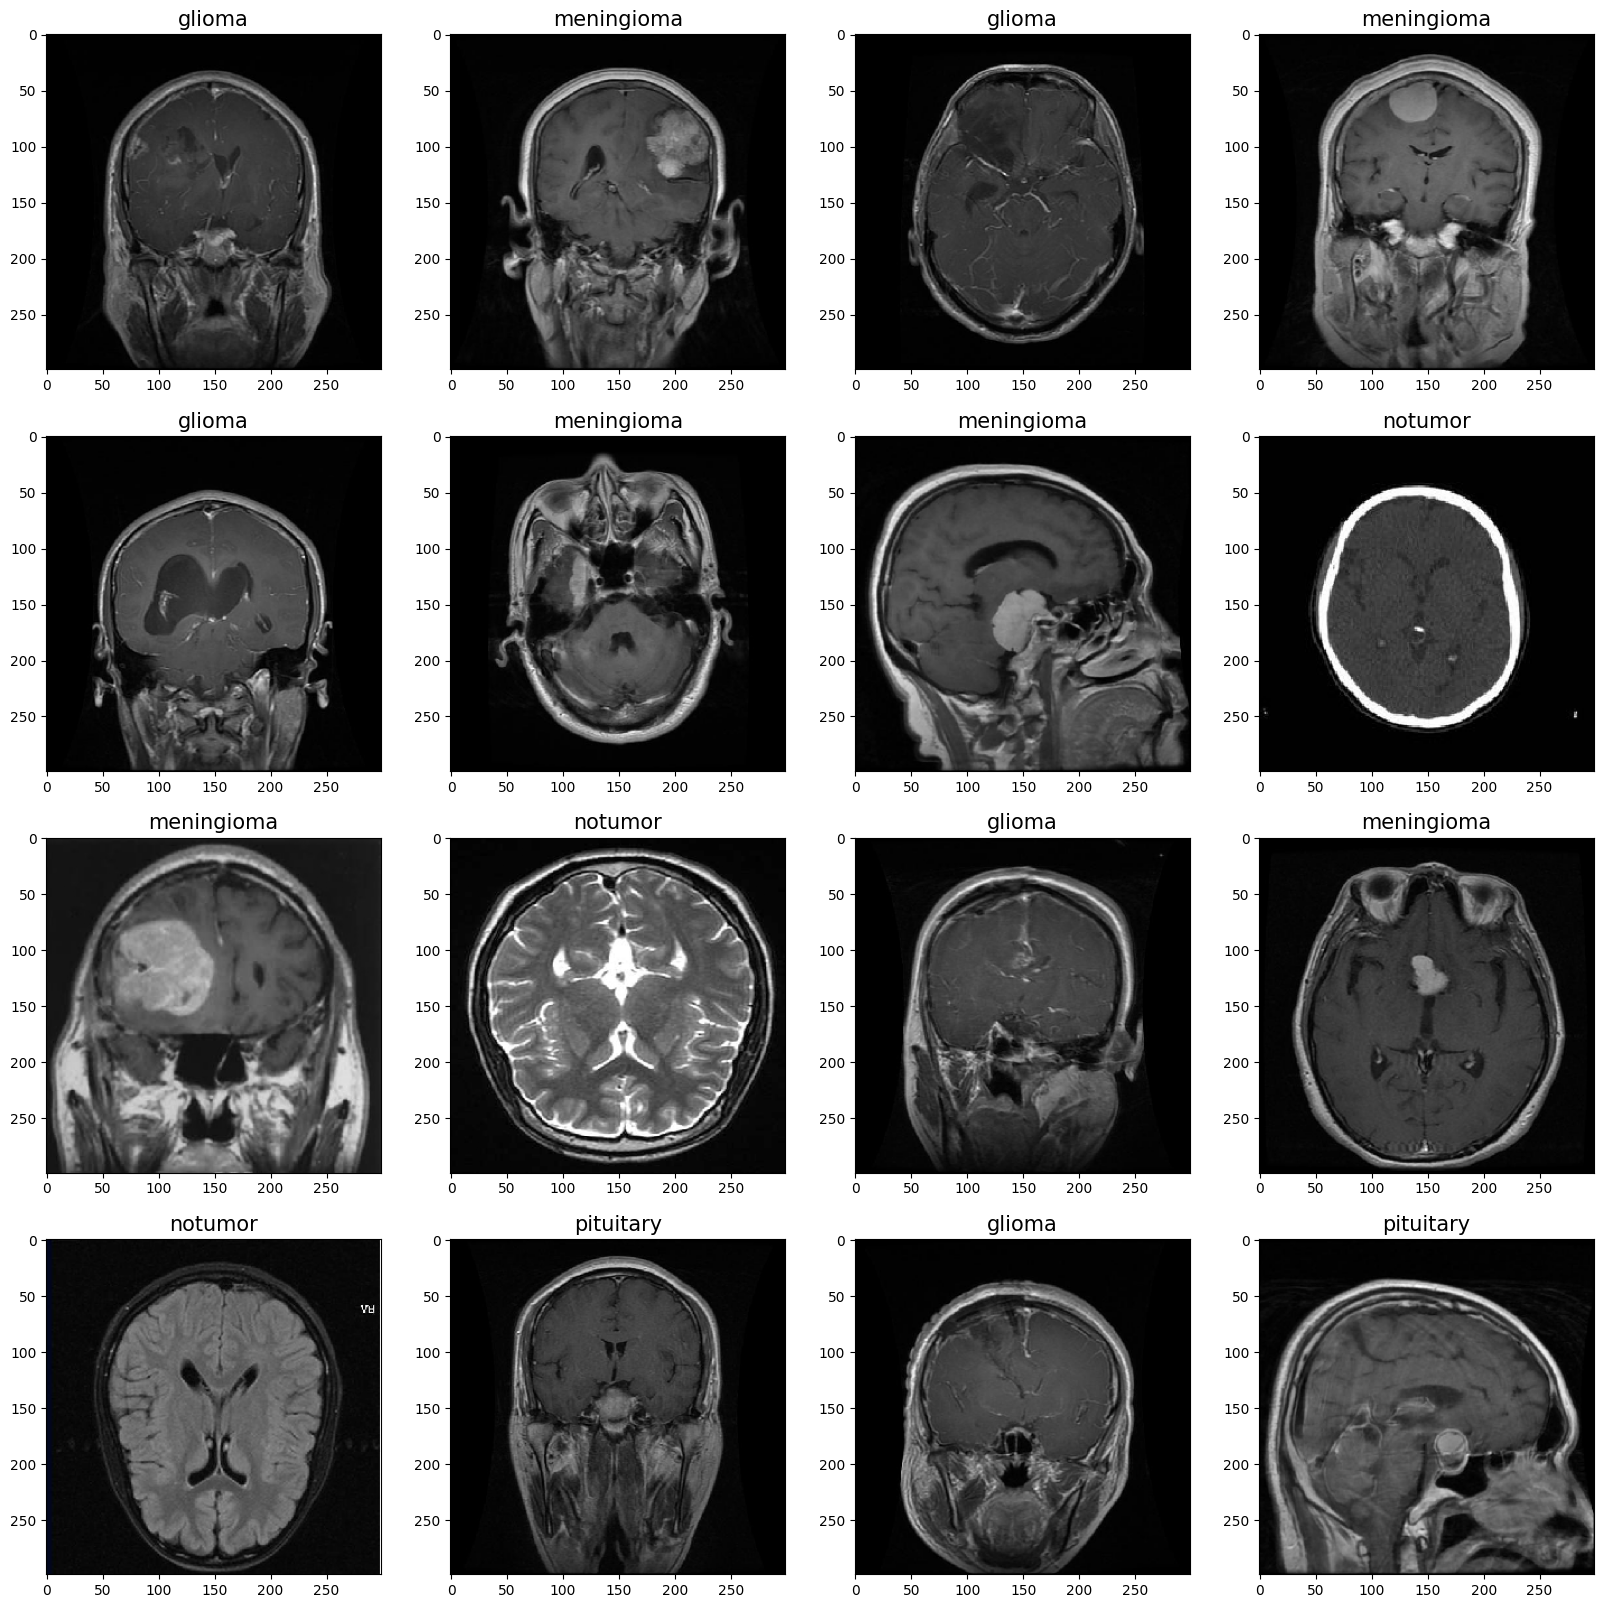

In [16]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [17]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                         

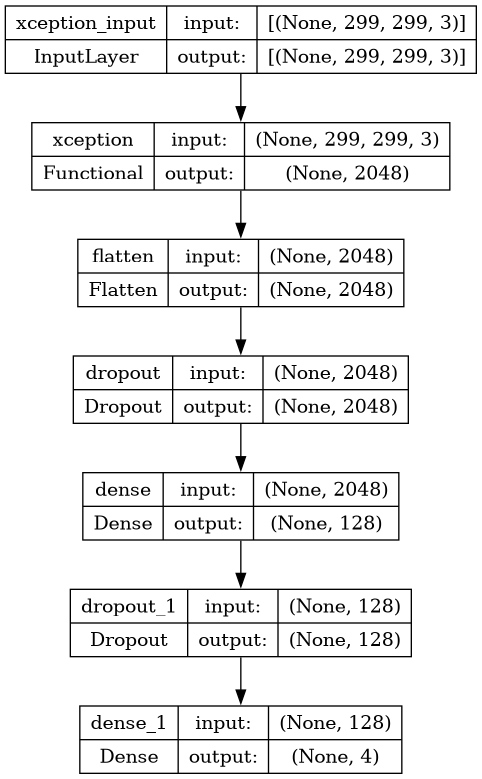

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

# 4. Training

In [19]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
179/179 [==============================] - 124s 511ms/step - loss: 0.3829 - accuracy: 0.8648 - precision: 0.9230 - recall: 0.8055 - val_loss: 0.1342 - val_accuracy: 0.9573 - val_precision: 0.9602 - val_recall: 0.9573
Epoch 2/10
179/179 [==============================] - 86s 479ms/step - loss: 0.0742 - accuracy: 0.9786 - precision: 0.9803 - recall: 0.9778 - val_loss: 0.1757 - val_accuracy: 0.9390 - val_precision: 0.9446 - val_recall: 0.9360
Epoch 3/10
179/179 [==============================] - 86s 479ms/step - loss: 0.0303 - accuracy: 0.9909 - precision: 0.9925 - recall: 0.9905 - val_loss: 0.0394 - val_accuracy: 0.9939 - val_precision: 0.9939 - val_recall: 0.9939
Epoch 4/10
179/179 [==============================] - 86s 479ms/step - loss: 0.0200 - accuracy: 0.9954 - precision: 0.9954 - recall: 0.9953 - val_loss: 0.0236 - val_accuracy: 0.9909 - val_precision: 0.9909 - val_recall: 0.9909
Epoch 5/10
179/179 [==============================] - 86s 479ms/step - loss: 0.0140 - accur

In [20]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

## 4.1 Visualize model performance

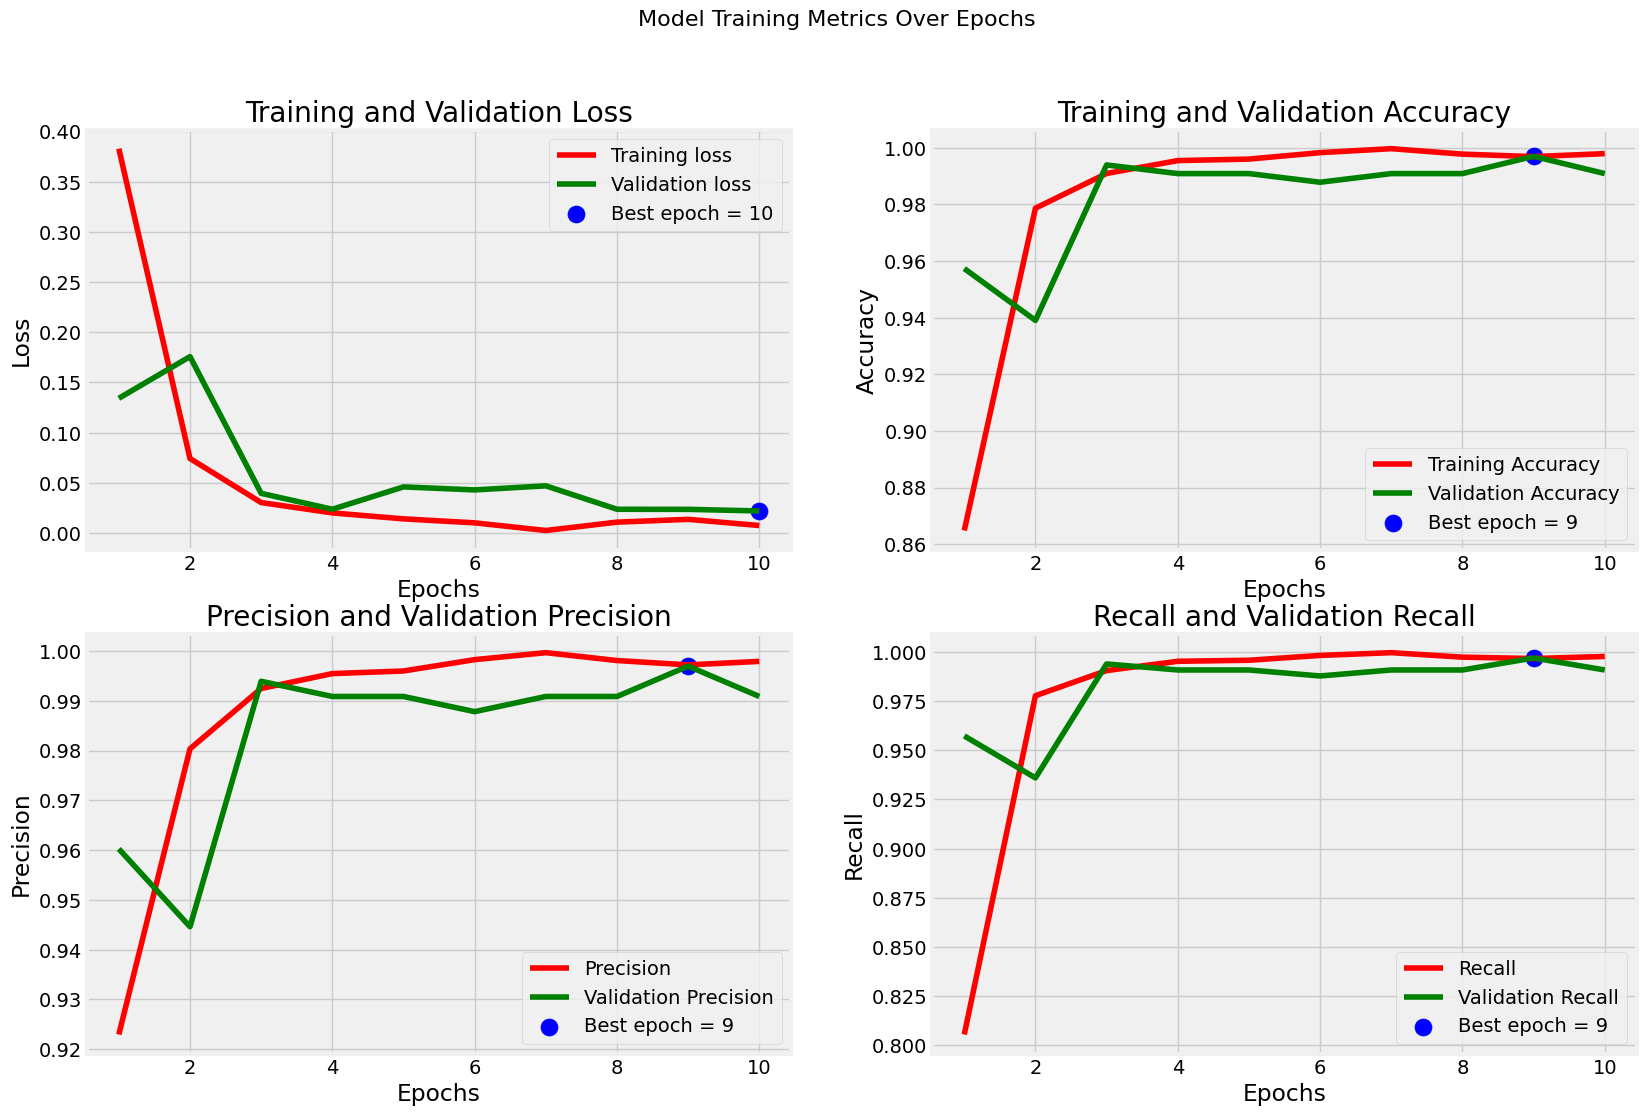

In [21]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

**RESNET MODEL**

In [22]:
img_shape = (299, 299, 3)

# Load the ResNet50 model, pre-trained on ImageNet
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet",
                                            input_shape=img_shape, pooling='max')

# Example: To freeze the layers of the base model so they are not trained
# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')  # Assuming you are working with 4 classes
])

model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                       

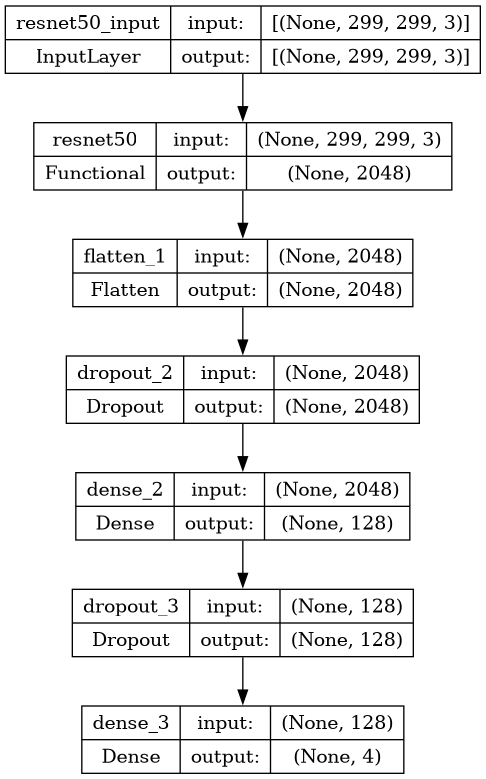

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',    
    patience=10,           
    verbose=1,             
    mode='auto',           
    restore_best_weights=True  
)

In [25]:
hist = model.fit(tr_gen,
                 epochs=30,
                 validation_data=valid_gen,
                 callbacks=[early_stopping_monitor],
                 shuffle= False)

Epoch 1/30
179/179 [==============================] - 101s 352ms/step - loss: 1.1312 - accuracy: 0.8265 - precision_1: 0.8486 - recall_1: 0.8037 - val_loss: 2.2709 - val_accuracy: 0.2287 - val_precision_1: 0.2287 - val_recall_1: 0.2287
Epoch 2/30
179/179 [==============================] - 59s 327ms/step - loss: 0.2282 - accuracy: 0.9282 - precision_1: 0.9374 - recall_1: 0.9182 - val_loss: 1.7756 - val_accuracy: 0.2409 - val_precision_1: 0.2500 - val_recall_1: 0.2226
Epoch 3/30
179/179 [==============================] - 59s 327ms/step - loss: 0.1565 - accuracy: 0.9496 - precision_1: 0.9542 - recall_1: 0.9443 - val_loss: 1.5039 - val_accuracy: 0.3750 - val_precision_1: 0.4946 - val_recall_1: 0.2774
Epoch 4/30
179/179 [==============================] - 59s 328ms/step - loss: 0.1121 - accuracy: 0.9650 - precision_1: 0.9686 - recall_1: 0.9617 - val_loss: 1.1627 - val_accuracy: 0.4817 - val_precision_1: 0.6553 - val_recall_1: 0.4116
Epoch 5/30
179/179 [==============================] - 59s 3

In [26]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

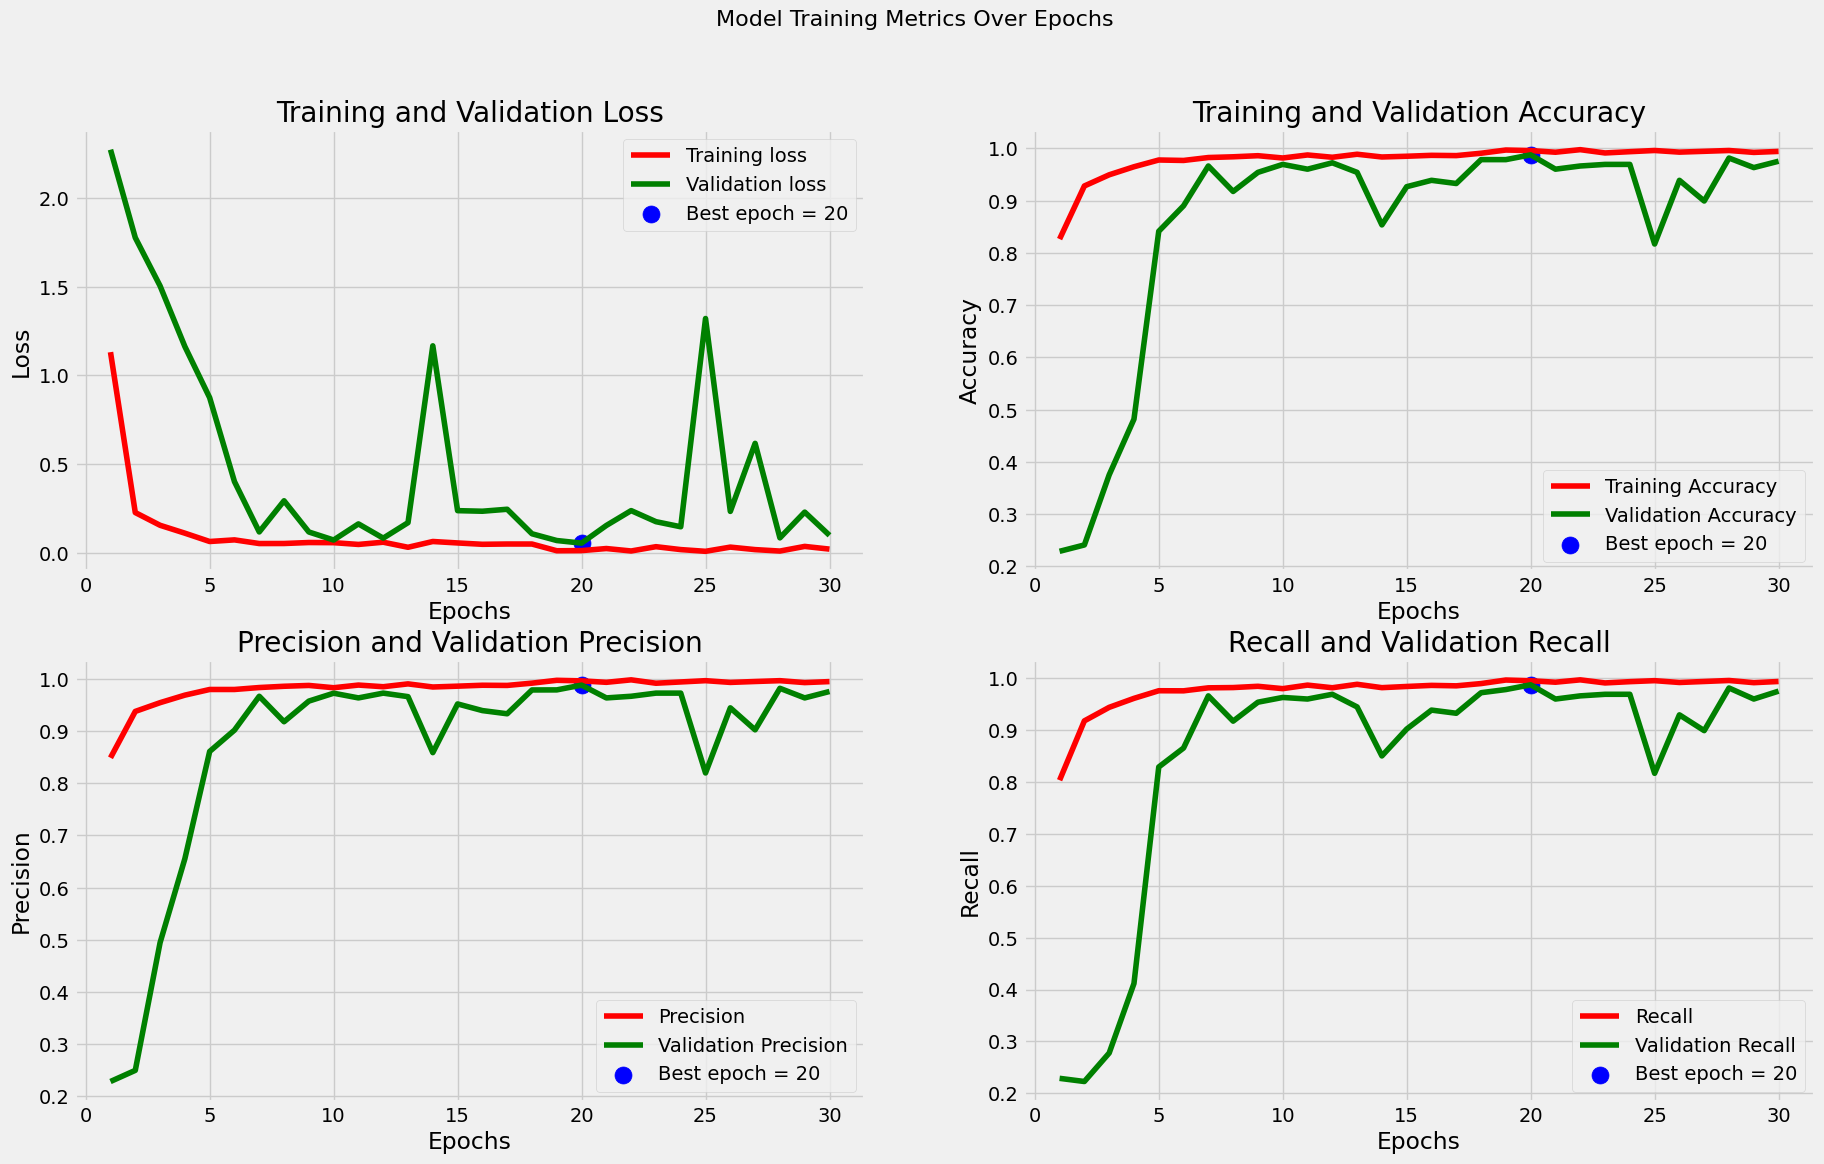

In [29]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_precision_1 = hist.history['precision_1']
tr_recall_1 = hist.history['recall_1']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_precision_1 = hist.history['val_precision_1']
val_recall_1 = hist.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_precision_1)
per_highest = val_precision_1[index_precision]
index_recall = np.argmax(val_recall_1)
recall_highest = val_recall_1[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_precision_1, 'r', label='Precision')
plt.plot(Epochs, val_precision_1, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall_1, 'r', label='Recall')
plt.plot(Epochs, val_recall_1, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()


VIT MODEL substitute Blip

In [33]:
!pip install transformers
from transformers import ViTModel, ViTFeatureExtractor



In [34]:
vit_model_name = "google/vit-base-patch16-224"

# Load the ViT model and feature extractor
vit_model = ViTModel.from_pretrained(vit_model_name)
vit_feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [35]:
batch_size = 32
vit_img_size = (224, 224)  # Assuming your chosen ViT model requires 224x224 images

# Define separate ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(rescale=1./255)  # Rescale to [0, 1]
valid_datagen = ImageDataGenerator(rescale=1./255)  # Rescale to [0, 1]

# Generators for training and validation data with ViT image size
train_generator = train_datagen.flow_from_dataframe(
    tr_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=batch_size,
    target_size=vit_img_size,
    class_mode="categorical"  # Assuming categorical labels
)

valid_generator_1 = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=batch_size,
    target_size=vit_img_size,
    class_mode="categorical"  # Assuming categorical labels
)

# Test data generator (without shuffling)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    ts_df,
    x_col="Class Path",
    y_col="Class",
    batch_size=16,
    target_size=vit_img_size,
    shuffle=False,
    class_mode="categorical"  # Assuming categorical labels
)


Found 5712 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.
Found 328 validated image filenames belonging to 4 classes.


In [49]:
# from transformers import ViTFeatureExtractor, TFAutoModel
# img_shape = (224, 224, 3)  # Adjust based on ViT model requirements

# # Create the sequential model
# images, labels = next(tr_gen)
# vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# # Create the sequential model
# model = Sequential([
#     # Create a ViT model
#     TFAutoModel.from_pretrained('google/vit-base-patch16-224-in21k', output_hidden_states=True),
#     Flatten(),
#     Dropout(rate=0.3),
#     Dense(128, activation='relu'),
#     Dropout(rate=0.25),
#     Dense(4, activation='softmax')  # Assuming you are working with 4 classes
# ])

# # Compile the model
# model.compile(optimizer=Adamax(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy', Precision(), Recall()])

# import numpy as np
# dummy_input = np.random.rand(1, 224, 3, 224)  # Assuming batch size of 1 and channels as the last dimension

# # Print model summary
# model.build(input_shape=dummy_input.shape)
# model.summary()
from tensorflow.keras.applications import EfficientNetB0  # For example, using EfficientNetB0 as a base model

# Load the base model (EfficientNetB0 in this example)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(vit_img_size[0], vit_img_size[1], 3))

# Define the rest of the model architecture and compile it as previously shown

# Define the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')  # Assuming you are working with 4 classes
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Display model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    epochs=20,  # You can adjust the number of epochs as needed
                    validation_data=valid_generator_1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten_8 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_201 (Dropout)       (None, 62720)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               8028288   
                                                                 
 dropout_202 (Dropout)       (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 4)                 516       
                                                      

2024-03-15 05:32:45.545038: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


179/179 [==============================] - 79s 227ms/step - loss: 0.4865 - accuracy: 0.8761 - precision_7: 0.8901 - recall_7: 0.8603 - val_loss: 3.7430 - val_accuracy: 0.2287 - val_precision_7: 0.2287 - val_recall_7: 0.2287
Epoch 2/20
179/179 [==============================] - 39s 216ms/step - loss: 0.1217 - accuracy: 0.9601 - precision_7: 0.9633 - recall_7: 0.9557 - val_loss: 2.0573 - val_accuracy: 0.2500 - val_precision_7: 0.2314 - val_recall_7: 0.1707
Epoch 3/20
179/179 [==============================] - 39s 216ms/step - loss: 0.0572 - accuracy: 0.9788 - precision_7: 0.9796 - recall_7: 0.9776 - val_loss: 3.8059 - val_accuracy: 0.2957 - val_precision_7: 0.2933 - val_recall_7: 0.2530
Epoch 4/20
179/179 [==============================] - 39s 216ms/step - loss: 0.0387 - accuracy: 0.9855 - precision_7: 0.9863 - recall_7: 0.9851 - val_loss: 5718.9702 - val_accuracy: 0.3049 - val_precision_7: 0.3049 - val_recall_7: 0.3049
Epoch 5/20
179/179 [==============================] - 39s 216ms/step

In [63]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from transformers import TFAutoModel

loaded_model = TFAutoModel.from_pretrained("keras-io/vit-small-ds")



# Assuming you have defined vit_img_size and train_generator, valid_generator_1 as before

# Define the rest of the model architecture
model = tf.keras.Sequential([
    loaded_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')  # Assuming 4 classes
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Display model summary
model.summary()

# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=valid_generator_1)


OSError: keras-io/vit-small-ds does not appear to have a file named config.json. Checkout 'https://huggingface.co/keras-io/vit-small-ds/main' for available files.

# 5. Testing and Evaluation

## 5.1 Evaluate

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

## 5.2 Testing

In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')